## Graph representaion class with NetworkX package
*requests as input a list of edges with a possible rating in the third column, or matrix market format*

In [87]:
import csv, enum, inspect
import networkx as nx
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.io import mmread
from networkx.algorithms import community as cmnt


class Graph:
    """
    Graph representation using NetworkX accepting csv data format
    """

    G = nx.Graph()  # networkx graph representation
    __communities = {"k_clique": None, "louvain": None, "kernighan": None}
    __modularity = {"k_clique": None, "louvain": None, "kernighan": None}

    class InputType:
        """Enum which represent extension of data file"""

        class Extension(enum.Enum):
            CSV = "CSV"

        class ColumnTypes(enum.Enum):
            SOURCE = "SOURCE"
            TARGET = "TARGET"
            WEIGHT = "WEIGHT"

        __extension = None
        __file_structure = ()

        def __init__(self, extension: Extension, data_type: tuple | None = None):
            if data_type:
                if not isinstance(data_type, tuple):
                    data_type = (data_type,)
                assert (
                    len(data_type) >= 2
                ), f"at least two types of columns are required"
                assert all(isinstance(val, self.ColumnTypes) for val in data_type), (
                    f"{list(inspect.signature(self.__init__).parameters.keys())[1]} "
                    f"must be instance of {self.ColumnTypes.__class__}"
                )
                assert len(set(data_type)) == len(data_type), (
                    f"column type values {[val.name for val in data_type]} must be mutually "
                    f"disjunctive"
                )
            self.__extension = extension
            self.__file_structure = data_type

        @property
        def ext(self) -> Extension:
            return self.__extension

        @property
        def struct(self) -> dict:
            return self.__file_structure

    def __init__(
        self,
        file_path: str,
        type: InputType.Extension,
        struct: tuple | None = (),
        delim: str | None = ",",
        has_header: bool | None = False,
    ):
        match type:
            case self.InputType.Extension.CSV:
                with open(file_path) as f:
                    data = csv.reader(f, delimiter=delim)
                    for i, row in enumerate(data):
                        if has_header and i == 0:
                            continue
                        data = {"weight": 1}
                        try:
                            for n in range(len(struct)):
                                self.__process_column_type(data, row, struct, n)
                        except IndexError as ex:
                            raise Exception(
                                f"you cannot define [{len(struct)}] types of columns, "
                                f"but your file has only [{len(row)}] columns"
                            )
                        self.G.add_edge(
                            u_of_edge=data["source"],
                            v_of_edge=data["target"],
                            weight=data["weight"],
                        )
            case _:
                raise NotImplementedError("Only csv is available")

    @property
    def k_clique_comm(self) -> list:
        self.__compute_community("k_clique")
        return {
            "community": self.__communities["k_clique"],
            "modularity": self.__modularity["k_clique"],
        }

    @property
    def louvain_comm(self) -> list:
        self.__compute_community("louvain")
        return {
            "community": self.__communities["louvain"],
            "modularity": self.__modularity["louvain"],
        }

    @property
    def kernighan_comm(self) -> list:
        self.__compute_community("kernighan")
        return {
            "community": self.__communities["kernighan"],
            "modularity": self.__modularity["kernighan"],
        }

    def __process_column_type(
        self, data: dict, row: list, struct: tuple, i: int
    ) -> None:
        if struct[i].name == self.InputType.ColumnTypes.SOURCE.name:
            data["source"] = row[i]
        if struct[i].name == self.InputType.ColumnTypes.TARGET.name:
            data["target"] = row[i]
        if struct[i].name == self.InputType.ColumnTypes.WEIGHT.name:
            data["weight"] = row[i]

    def __compute_community(self, type: str) -> None:
        match type:
            case "k_clique":
                k_clique = []
                k_small = input(
                    "Define smalles size of clique for computation of community"
                )
                for i, x in enumerate(cmnt.k_clique_communities(g.G, int(k_small))):
                    k_clique.append(set(x))
                self.__communities["k_clique"] = k_clique
            case "louvain":
                seed = input("Define seed for algorithm")
                louvain = cmnt.louvain_communities(g.G, None, seed=int(seed))
                self.__communities["louvain"] = louvain
                self.__modularity["louvain"] = cmnt.modularity(g.G, louvain)
            case "kernighan":
                max_iter = input("Define maximum number of iteration until give up")
                kernighan = cmnt.kernighan_lin_bisection(g.G, max_iter=max_iter)
                self.__communities["kernighan"] = kernighan

In [88]:
type = Graph.InputType(
    extension=Graph.InputType.Extension.CSV,
    data_type=(Graph.InputType.ColumnTypes.SOURCE, Graph.InputType.ColumnTypes.TARGET),
)
g = Graph(
    file_path="KarateClub.csv",
    type=type.ext,
    struct=type.struct,
    has_header=False,
    delim=";",
)

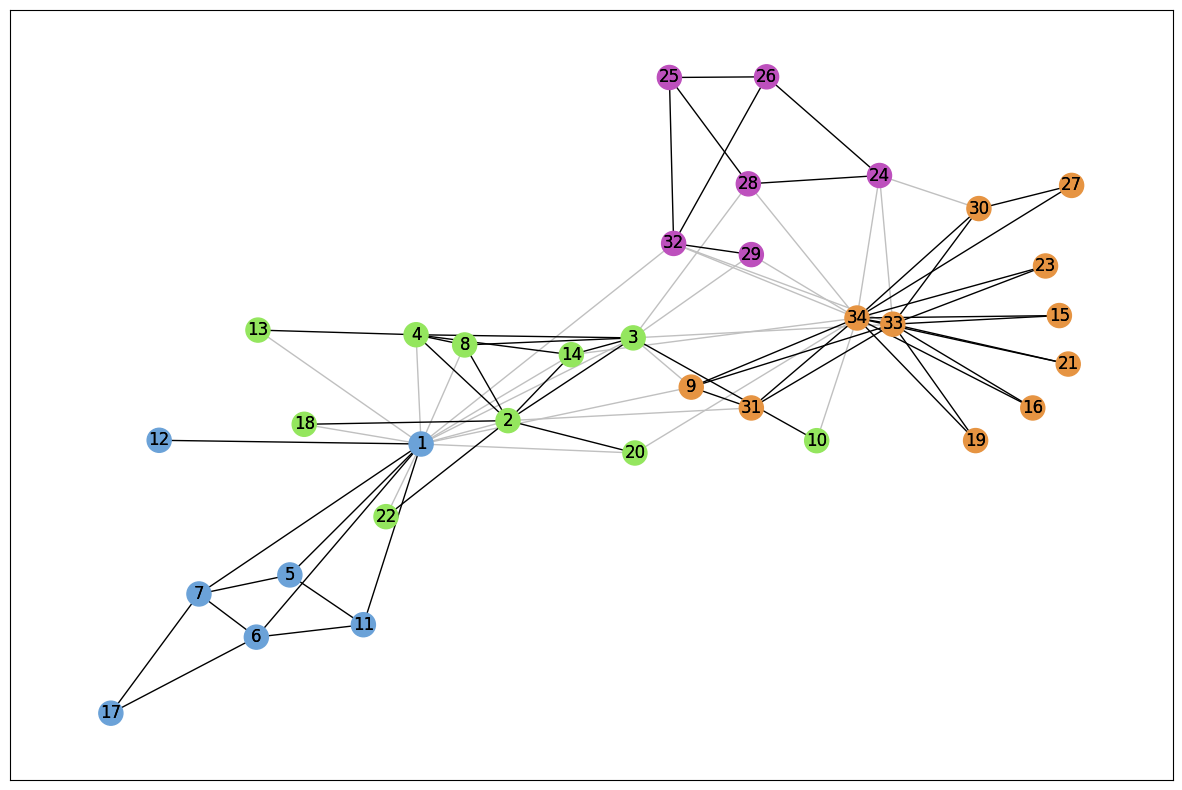

In [90]:
# GRAPH VIZUALIZATION
def assign_node_comm(G, communities) -> None:
    for i, x in enumerate(communities):
        for j in x:
            G.nodes[j]["community"] = i + 1

def assign_edge_comm(G) -> None:
    for (
        i,
        x,
    ) in G.edges:
        if G.nodes[i]["community"] == G.nodes[x]["community"]:
            G.edges[i, x]["community"] = G.nodes[i]["community"]
        else:
            G.edges[i, x]["community"] = 0

community = g.louvain_comm
assign_node_comm(g.G, community["community"])
assign_edge_comm(g.G)

def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

node_color = [get_color(g.G.nodes[v]['community']) for v in g.G.nodes]
external = [(v, w) for v, w in g.G.edges if g.G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g.G.edges if g.G.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

graph_pos = nx.spring_layout(g.G)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    g.G,
    pos=graph_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
nx.draw_networkx(
    g.G,
    pos=graph_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)